**Numerical Methods Coursework 1**

In [169]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as si
import seaborn as sns

# *European and American Options*

First specify tree parameterisation in the Kamrad-Ritchken model

In [170]:
def KRparam(lamda, sigma, dt, r):
    u = np.exp(lamda * sigma * np.sqrt(dt))
    qu = 1/ (2*lamda**2) + ((r - 0.5*sigma**2) * np.sqrt(dt)) / (2* lamda * sigma)
    qm = 1 - 1/lamda**2
    qd = 1/ (2*lamda**2) - ((r - 0.5*sigma**2) * np.sqrt(dt)) / (2* lamda * sigma)
    if (qu < 0 or qd < 0):
        print("The value of dt is too large and the probabilities will not be viable, please use a smaller value for dt.")
        return
    R = np.exp(r * dt)
    return u, qu, qm, qd, R

Specify the pricing algorithm

In [171]:
def TrinomialTreeEuropean(s0, u, qu, qm, qd, R, N, payoff):
    #initialize the array for stock price and option value
    S = np.zeros((2 * N + 1, N + 1))
    V = np.zeros((2 * N + 1, N + 1))
    for t in range(N+1):
        S[0:2*t+1, t] = s0 * u ** np.arange(t, -t-1, -1)

    #set the final payoff of the option
    V[:, N] = payoff(S[:,N])

    #backward induction
    for t in reversed(range(N)):
        continuation_val = (qu * V[0:2*t+1, t+1] + qm * V[1:2*t+2, t+1] + qd * V[2: 2*t+3, t+1])/R #R = exp(r * dt)
        V[0:2*t+1, t] = continuation_val
    
    return V





In [172]:
def TrinomialTreeAmerican(s0, u, qu, qm, qd, R, N, payoff):
    #initialize the array for stock price and option value
    S = np.zeros((2 * N + 1, N + 1))
    V = np.zeros((2 * N + 1, N + 1))
    for t in range(N+1):
        S[0:2*t+1, t] = s0 * u ** np.arange(t, -t-1, -1)

    #set the final payoff of the option
    V[:, N] = payoff(S[:,N])

    #backward induction
    for t in reversed(range(N)):
        continuation_val = (qu * V[0:2*t+1, t+1] + qm * V[1:2*t+2, t+1] + qd * V[2: 2*t+3, t+1])/R #R = exp(r * dt)
        V[0:2*t+1, t] = np.maximum(payoff(S[0:2*t+1, t]), continuation_val)
        
    
    return (V, continuation_val[0])

*Implementation of the algorithm for different values of the parameters for European call option*


In part 1. (b), vary $N$, $\lambda$ and $S_0$

In [173]:
#========1.(b)==========
s0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100 
lamda_val = np.array([1,1.25, 1.5, 1.75])
CallPayoff = lambda x: np.maximum(x - K,0)

def varyNandlamda (s0, N_val, r, T, sigma, K):
    TriTreePrices = np.zeros((len(N_val), len(lamda_val)))
    for i in range(len(lamda_val)):
        lamda = lamda_val[i]
        for j in range(len(N_val)):
            N = N_val[j]
            u, qu, qm, qd, R = KRparam(lamda, sigma, T/N, r)
            V = TrinomialTreeEuropean(s0, u, qu, qm, qd, R, N, CallPayoff)
            TriTreePrices[j,i] = V[0,0]

    European_V = pd.DataFrame(TriTreePrices, columns = [r'$\lambda$=1',r'$\lambda$=1.25',r'$\lambda$=1.5',r'$\lambda$=1.75'], index = N_val, )
    bscall = BS_call(s0, K, T, r, sigma)

    return European_V, bscall

        


Plot the trinomial tree prices against $N$ for different $\lambda$, and compare with the value given by the Black-Scholes formula

<Figure size 432x288 with 0 Axes>

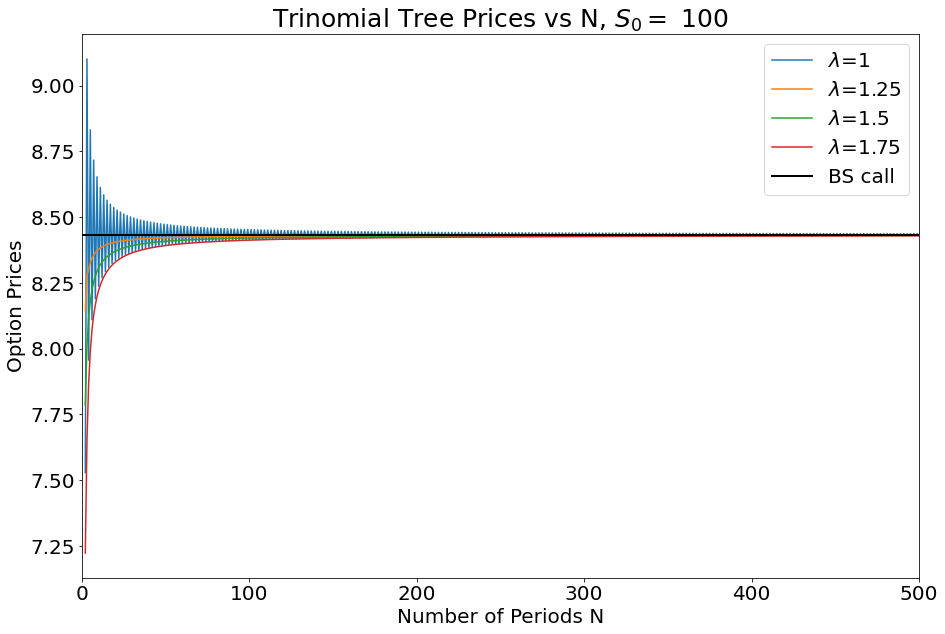

<Figure size 432x288 with 0 Axes>

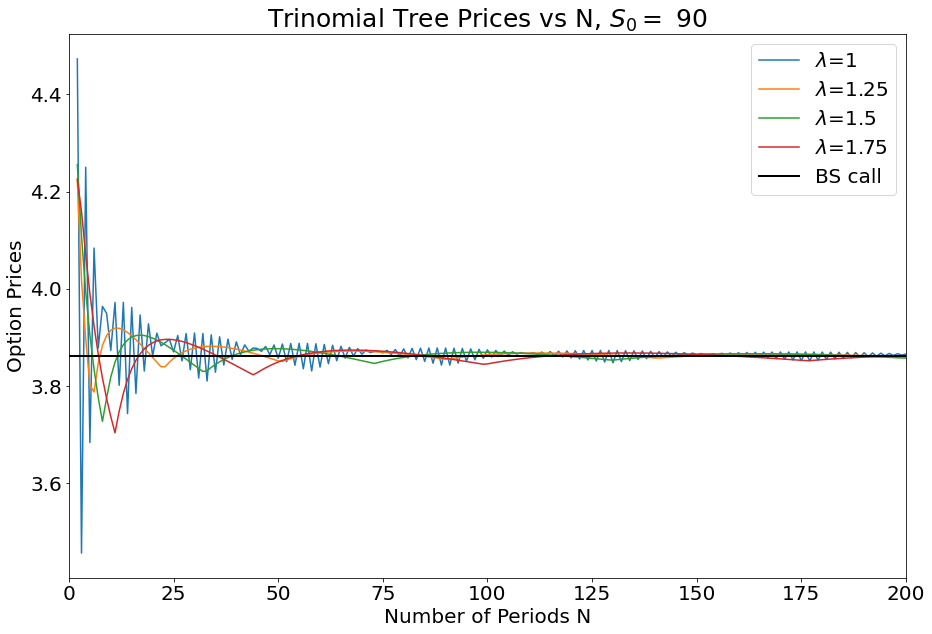

<Figure size 432x288 with 0 Axes>

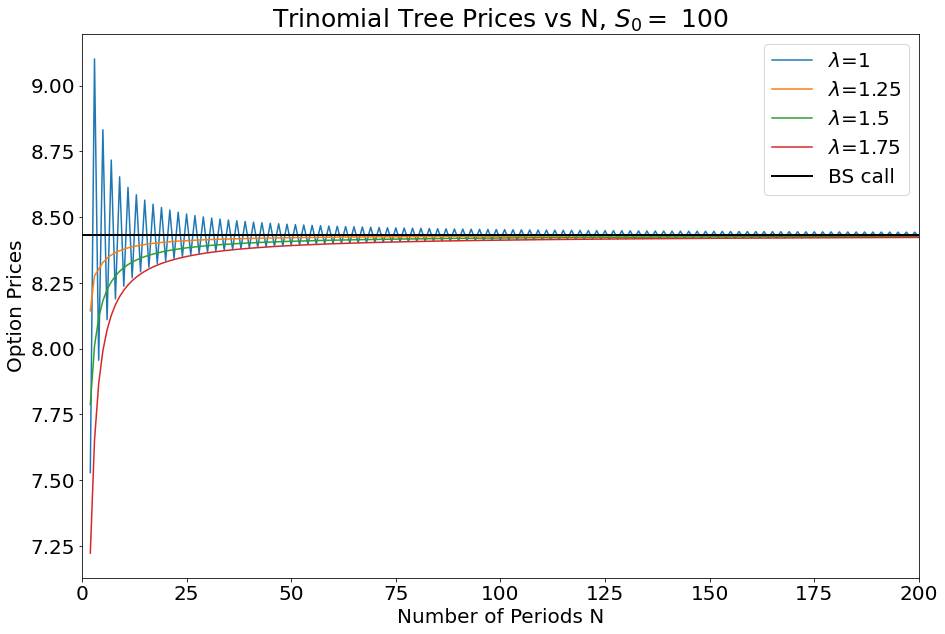

<Figure size 432x288 with 0 Axes>

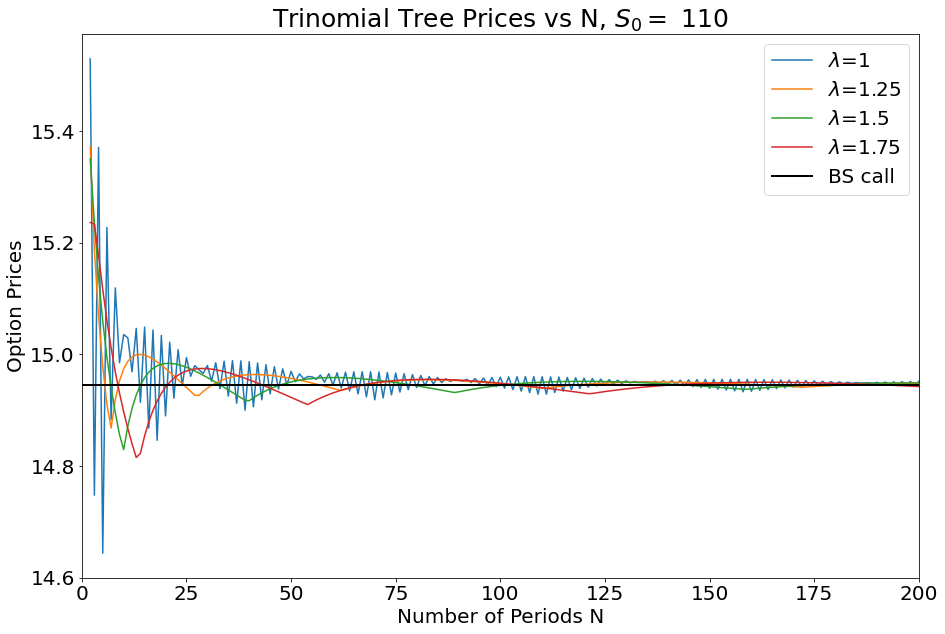

In [174]:
def BS_call(S, K, T, r, sigma):
        
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

#make the plot
def plotagainstN (s0, N_val):
     
    plt.figure()
    European_V, bscall = varyNandlamda( s0, N_val, r, T, sigma, K )
    ax1 = European_V.plot(title = r'Trinomial Tree Prices vs N, $S_0 =$ {}'.format(s0),
                        figsize = (15,10),fontsize = 20, xlim = [0,len(N_val)+1])
    ax1.title.set_size(25)
    ax1.axhline(y = bscall , color = 'k', linewidth = 2, linestyle = '-',label = 'BS call')
    ax1.set_xlabel('Number of Periods N',fontsize = 20)
    ax1.set_ylabel('Option Prices', fontsize = 20)
    ax1.legend(loc=1,fontsize=20)
    plt.savefig('plotoverN{}_{}.pdf'.format(s0,len(N_val)+1))
    plt.show()

plotagainstN(100,np.arange(2,501))
plotagainstN(90,np.arange(2,201))
plotagainstN(100,np.arange(2,201))
plotagainstN(110,np.arange(2,201))


In part 1.(c), fix $N = 500$, $K =100$ and explore the difference between trinomial tree price and BS price for different values of $S_0$ and $\lambda$.

In [175]:
#========1.(c)=======
r, T, sigma, K ,N =  0.01, 1, 0.2, 100, 500
s0_min = 70
s0_max = 130
s0_val = np.linspace(s0_min,s0_max,71)
price_diff = np.zeros((len(lamda_val), len(s0_val)))

for i in range(len(lamda_val)):
    lamda = lamda_val[i]
    u, qu, qm, qd, R = KRparam(lamda, sigma, T/N, r)
    for j in range(len(s0_val)):
        s0 = s0_val[j]
        V = TrinomialTreeEuropean(s0, u, qu, qm, qd, R, N, CallPayoff)
        bscall = BS_call(s0, K, T, r, sigma)
        price_diff[i,j] = (V[0,0] - bscall)*1000  #we magnify the difference by 10^3 for better accuracy
price_diff_table = pd.DataFrame(price_diff.T, index = s0_val, columns = [r'$\lambda$=1',r'$\lambda$=1.25',r'$\lambda$=1.5',r'$\lambda$=1.75'] )

        
        



In [176]:
price_diff_table

,$\lambda$=1,$\lambda$=1.25,$\lambda$=1.5,$\lambda$=1.75
70.000000,-1.210667,-0.595222,0.035952,0.038075
70.857143,-0.457633,-0.456734,-0.022627,-0.777752
71.714286,-0.024615,-0.343370,-0.194459,0.083323
72.571429,-1.329163,-0.251301,-0.545324,0.522736
73.428571,-0.360352,-0.175594,-0.952392,0.235972
...,...,...,...,...
126.571429,-0.669412,-0.797737,0.661023,-1.510579
127.428571,1.059557,0.142104,-1.070855,1.006675
128.285714,-1.761519,-0.024100,0.570037,-1.026116
129.142857,0.237906,-0.568321,-1.055787,0.614146


In [177]:
abs_diff_table = abs(price_diff_table)
abs_diff = abs(price_diff_table).mean(axis = 0)
abs_diff

$\lambda$=1       1.741985
$\lambda$=1.25    0.665720
$\lambda$=1.5     0.960599
$\lambda$=1.75    0.994197
dtype: float64

In [178]:
relative_mag = abs_diff_table.iloc[:,1] > abs_diff_table.iloc[:,2]
relative_mag.mean()


0.323943661971831

*Implementation of the algorithm for American Call Options*

In part 2.(b), compare the time-zero value of time-zero value of an American call option and its intrinsic value agaiinst different initial stock prices $S_0$.

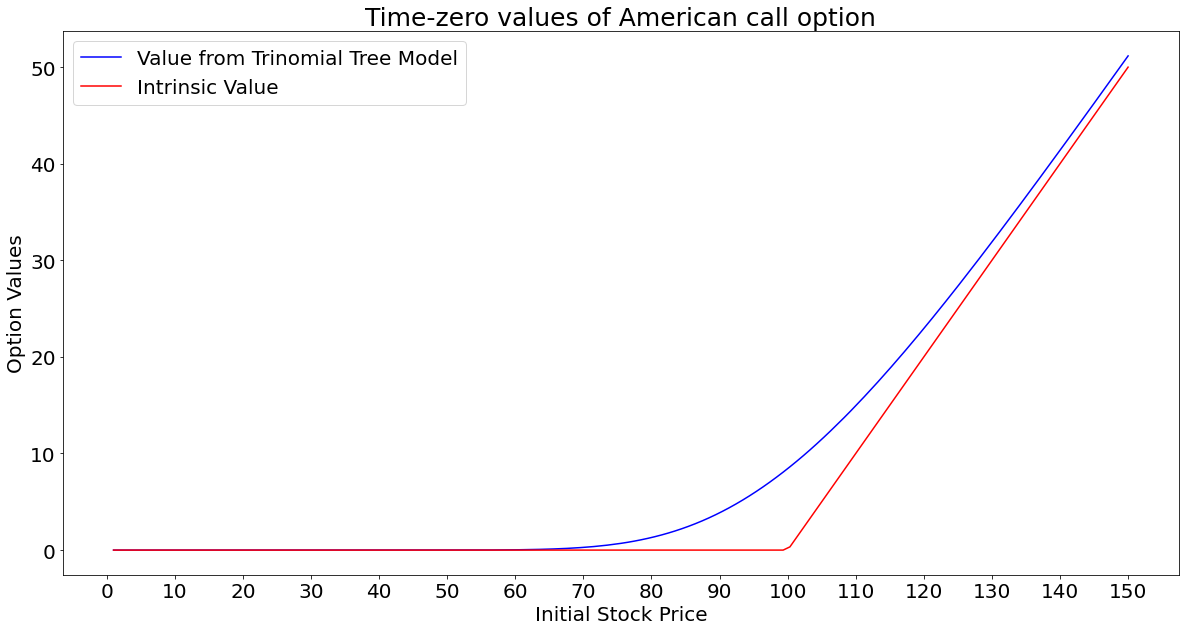

In [179]:
r, T, sigma, K ,N, lamda =  0.01, 1, 0.2, 100, 500, 1.25
u, qu, qm, qd, R = KRparam(lamda, sigma, T/N, r)
s0_min = 1
s0_max = 150
s0_val = np.linspace(s0_min,s0_max,151)

American_call_intrinsic = CallPayoff(s0_val)
American_call_V = np.array([TrinomialTreeAmerican(s0, u, qu, qm, qd, R, N, CallPayoff)[0][0,0] for s0 in s0_val])
data = np.column_stack([American_call_intrinsic, American_call_V])
early_exercise_data_call = pd.DataFrame(data= data, index = s0_val, columns = ['American call intrinsic value', 'American call option value'])

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(s0_val, early_exercise_data_call['American call option value'], color = 'b', label = 'Value from Trinomial Tree Model')
ax.plot(s0_val, early_exercise_data_call['American call intrinsic value'], color = 'r', label = "Intrinsic Value")
ax.set_xlabel('Initial Stock Price', fontsize = 20)
ax.set_ylabel('Option Values', fontsize = 20)
ax.set_title('Time-zero values of American call option', fontsize = 25)
plt.xticks(np.arange(0,160,10),fontsize = 20)
plt.yticks(fontsize = 20)
ax.legend(loc = 2, fontsize = 20)
plt.savefig('american_call.pdf')


In [180]:
100/u**500


0.37343931739807495

In part 2.(c), we work with American put options and explore the early exercise strategy when volatility $\sigma$ and interest rate $r$ change.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


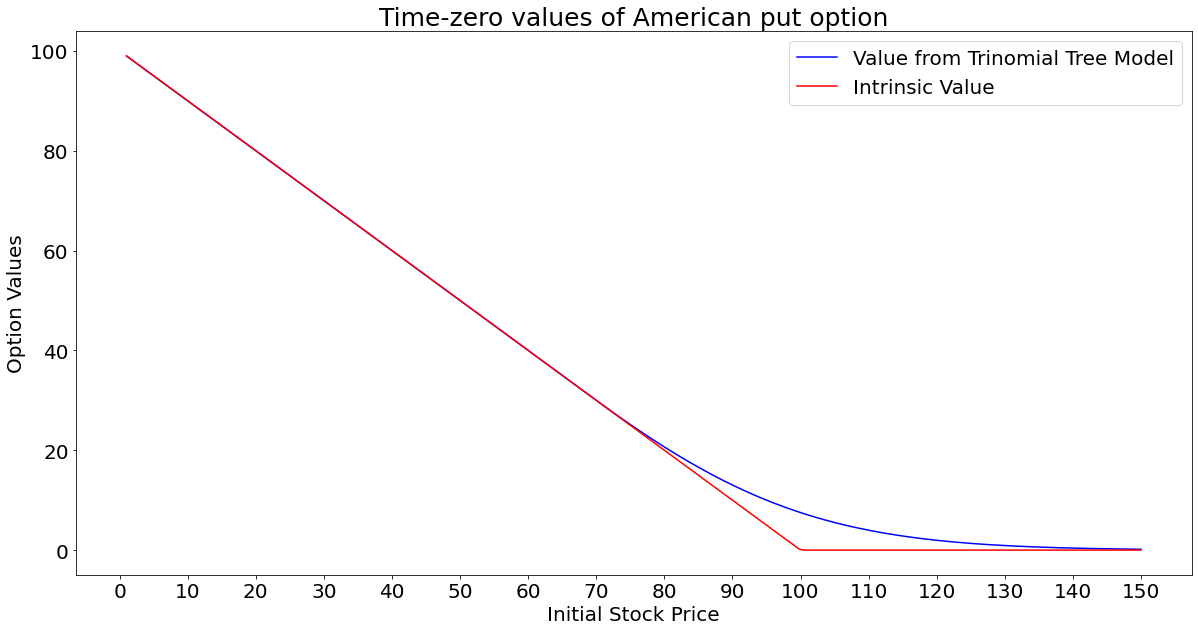

In [181]:
r, T, sigma, K ,N, lamda =  0.01, 1, 0.2, 100, 500, 1.25
u, qu, qm, qd, R = KRparam(lamda, sigma, T/N, r)
s0_min = 1
s0_max = 150
s0_val = np.linspace(s0_min,s0_max,200)

PutPayoff = lambda x : np.maximum(K - x, 0)
A_Put_intrinsic = PutPayoff(s0_val)
A_Put_V = np.array([TrinomialTreeAmerican(s0, u, qu, qm, qd, R, N, PutPayoff)[0][0,0] for s0 in s0_val])
data = np.column_stack([A_Put_intrinsic.T, A_Put_V.T])
early_exercise_data_put = pd.DataFrame(data= data, index = s0_val, columns = ['American put intrinsic value', 'American put option value'])
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(s0_val, early_exercise_data_put['American put option value'], color = 'b', label = 'Value from Trinomial Tree Model')
ax.plot(s0_val, early_exercise_data_put['American put intrinsic value'], color = 'r', label = "Intrinsic Value")
ax.set_xlabel('Initial Stock Price', fontsize = 20)
ax.set_ylabel('Option Values', fontsize = 20)
ax.set_title('Time-zero values of American put option', fontsize = 25)
plt.xticks(np.arange(0,160,10),fontsize = 20)
plt.yticks(fontsize = 20)
ax.legend(fontsize = 20)

plt.savefig("american_put_intrinsic_v_trinomial.eps")

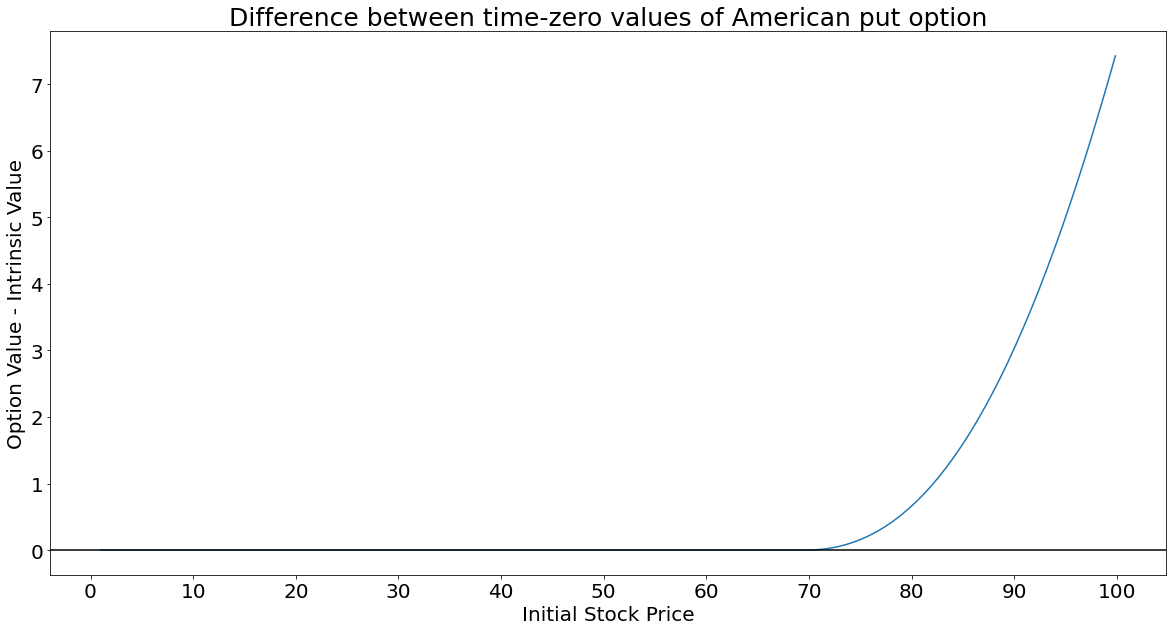

In [182]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(early_exercise_data_put[0:100]['American put option value'] - early_exercise_data_put[0:100]['American put intrinsic value'])
ax.set_xlabel('Initial Stock Price', fontsize = 20)
ax.set_ylabel('Option Value - Intrinsic Value', fontsize = 20)
ax.set_title('Difference between time-zero values of American put option', fontsize = 25)
plt.xticks(np.arange(0,110,10),fontsize = 20)
plt.yticks(fontsize = 20)
ax.axhline(0, color = 'black')
plt.savefig("ValueDifferencePut.eps")

In [183]:
def find_early_exercise_cutoff(r, T, sigma, K ,N, lamda):
    u, qu, qm, qd, R = KRparam(lamda, sigma, T/N, r)
    s0_min = 1
    s0_max = 100
    s0_val = np.linspace(s0_min,s0_max,200)

    PutPayoff = lambda x : np.maximum(K - x, 0)
    A_Put_intrinsic = PutPayoff(s0_val)
    A_Put_V = np.array([TrinomialTreeAmerican(s0, u, qu, qm, qd, R, N, PutPayoff)[0][0,0] for s0 in s0_val])
    
    difference = pd.Series(A_Put_V - A_Put_intrinsic, index=s0_val)

    if (difference.size == 0):
        return -1
    return difference[difference > 0].index[0]
    

In [184]:

find_early_exercise_cutoff(0.2, T, 0.3, K ,N, lamda)

84.57788944723617

In [185]:
sigma_range = np.linspace(0.01, 0.3, 31)
r_range = np.linspace(0, 0.1, 101)
cutoff_points = np.zeros([101, 31])

for s_index, s in enumerate(sigma_range):
    print(s)
    for r_index, r_temp in enumerate(r_range):
        cutoff = find_early_exercise_cutoff(r_temp, T, s, K ,N, lamda)
        cutoff_points[r_index, s_index] = cutoff

cutoff_df = pd.DataFrame(cutoff_points)
cutoff_df.to_pickle("cutoff_dataframe")

0.01


KeyboardInterrupt: 

<AxesSubplot:>

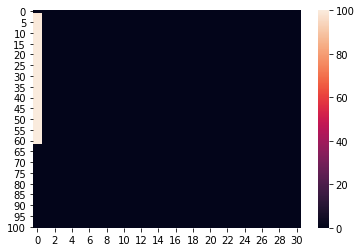

In [186]:
sns.heatmap(cutoff_points)

Question 3)

Firstly we define the Kamrad-Ritchken model.

In [187]:

def create_trinomial_model_kamrad_ritchken(s0, r, dt, sigma, N, lamda):
    #model parameters
    
    u, qu, qm, qd, R = KRparam(lamda, sigma, dt, r)

    if (qu < 0 or qd < 0):
        print("The value of dt is too large and the probabilities will not be viable, please use a smaller value for dt.")
        return

    # Set up the tree via S[n,k] = s0 * u^(k-n)
    prices = np.zeros((N+1, 2*N+1))
    for t in range(N+1):
        prices[t, 0:2*t+1] = s0 * u**np.arange(t, -t-1, -1)

    return (prices, np.array([qd, qm, qu]), u)

    
        

We create an array of prices for $A^n_j$ noticing that these prices have no dependence on $n$.

In [189]:
def create_auxillary_values(s0, N, u):
    indices = np.arange(0,N+1)
    AValues = s0*u**indices
    return AValues

Next we define the funtion for generating the prices by backward induction

In [190]:
def generate_lookback_prices_optimized(s0, r, dt, sigma, N, lamda, american = False):
    Nfloor_div_2 = N//2     
    prices, probabilities, u = create_trinomial_model_kamrad_ritchken(s0, r, dt, sigma,  N, lamda)
    auxillary_values = create_auxillary_values(s0, N, u)
            
    # Option values matrix indexed by time, k, j
    option_values = np.zeros([N+1, 2*N+1, Nfloor_div_2+1])

    # Terminal condition: option values given by terminal payoff

    terminal_stock_price = prices[N]
    k_range = np.arange(0,2*N + 1)
    j_range = np.arange(0, Nfloor_div_2+1)

    #find x such that A^N_{k,j} = S_0u**x indexed by k, j
    #Note this can produce negative indexes, but these represent impossible situations
    #so they will not impact any resulting prices.
    auxiliary_variable_index = N-((k_range+1)//2)[:,np.newaxis] - Nfloor_div_2 + j_range[np.newaxis, :]
    option_values[N] = np.maximum(np.take_along_axis(auxillary_values[np.newaxis,:], auxiliary_variable_index, axis = 1) - terminal_stock_price[:,np.newaxis], np.zeros(1)[:,np.newaxis])


    # Backward induction
    # Loop in time
    for n in reversed(range(N)):
        #generate the possible values of k_new indexed by current k, stock movement where for the stock movement 0 is down, 1 is no movement, 2 is up.
        current_k = np.arange(0,2*n+1)
        k_new = np.column_stack([current_k+2, current_k+1, current_k])
        floor_k_new_div_2 = k_new//2
        ceil_k_div_2 = (current_k+1)//2
        floor_k_div_2 = current_k//2
        j_range = np.arange(Nfloor_div_2-n//2, Nfloor_div_2+1)
        alpha = (k_new[:,np.newaxis, :]+1)//2 - 1 - ceil_k_div_2[:, np.newaxis, np.newaxis] + j_range[np.newaxis,:,np.newaxis]
        beta = Nfloor_div_2 - floor_k_new_div_2[:,np.newaxis, :]

        #Use the shooting function to generate the possible values of jnew indexed by current k, current j, stock movement where for the stock movement 0 is down, 1 is no movement, 2 is up.
        phi_result = np.maximum(alpha, beta)

        #calculate the option prices using backward induction
        v_down = np.take_along_axis(option_values[n+1, current_k+2, :], phi_result[:,:,0], axis = 1)
        v_mid = np.take_along_axis(option_values[n+1, current_k + 1, :], phi_result[:,:,1], axis = 1)
        v_up = np.take_along_axis(option_values[n+1, current_k, :], phi_result[:,:,2], axis = 1)
        discounted_continuation_values = np.exp(-1*r*dt)*(probabilities[0]* v_down +  probabilities[1]* v_mid + probabilities[2]* v_up)

        if american:

            #find x such that A^n_{k,j} = S_0u**x indexed again by k, j
            auxiliary_variable_index = n-((current_k+1)//2)[:,np.newaxis] - Nfloor_div_2 + j_range[np.newaxis, :]
            #(current_k//2)[:,np.newaxis] - Nfloor_div_2 + j_range[np.newaxis, :]
            current_stock_price = prices[n]
            exercise_values = np.maximum(np.take_along_axis(auxillary_values[np.newaxis,:], auxiliary_variable_index, axis = 1) - current_stock_price[current_k, np.newaxis], np.zeros(1)[:,np.newaxis])
            option_values[n][0:2*n+1,j_range] = np.maximum(exercise_values, discounted_continuation_values)
        else:
            option_values[n][0:2*n+1,j_range] =  discounted_continuation_values


    #print the fair price for the initial time
    return option_values[0,0,Nfloor_div_2]

In [191]:
generate_lookback_prices_optimized(100, 0, 1, 0.1, 3, 1.25, False)

9.156711075913583

We include a less optimised version for reference, the output is the same in both cases

In [192]:
def generate_lookback_prices(s0, r, dt, sigma, N, lamda, american = False):
    Ndiv2 = N//2
    prices, probabilities, u = create_trinomial_model_kamrad_ritchken(s0, r, dt, sigma,  N, lamda)
            
    # Option values matrix
    OptPx = np.zeros([N+1, 2*N+1, Ndiv2+1])
    
    
    # Terminal condition: option values given by terminal payoff
    for k in range(2*N+1):
        j_range = np.arange(0, Ndiv2+1)
        OptPx[N, k, j_range] = np.maximum(s0 * u **(k//2 -N//2 + j_range) - prices[N, N-k], 0)

        
    for n in reversed(range(N)):
        # Loop across each stock price index k
        for k in range(2*n+1):
            
            j_range = np.arange(0, N//2+1)
            
            alpha = k//2 + j_range
            phi_up = -1 *((k+2)//2) + np.maximum(alpha, N//2 + (k+2) - n - 1)  
            phi_mid = -1 *((k+1)//2) + np.maximum(alpha, N//2 + (k+1) - n - 1)
            phi_down = -1 * (k//2) + np.maximum(alpha, N//2 + k - n - 1)
            
            V_up = OptPx[n+1, k+2, phi_up]
            V_mid = OptPx[n+1, k+1, phi_mid]
            V_down = OptPx[n+1, k, phi_down]
            
            
            
            # the backward induction step
            if american:
                OptPx[n, k, j_range] = np.maximum(np.maximum(s0 * u **(k//2 -N//2 + j_range) - prices[n, k], 0), np.exp(-1*r*dt)*(probabilities[2]*V_up + probabilities[1]*V_mid + probabilities[0]*V_down))
            else:
                OptPx[n,k,j_range] = np.exp(-1*r*dt)*(probabilities[2]*V_up + probabilities[1]*V_mid + probabilities[0]*V_down)

            
        
    return OptPx[0,0,N//2]

*Finally let's run the code to obtain the price

In [195]:
s0 = 100
r = 0.01

sigma = 0.1
N = np.array([1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]) 
dt = 1/N
lamda = 1.25


In [196]:
generate_lookback_prices_optimized(s0, r, 1/700, sigma, 700, lamda, False)
performance_data_optimized = pd.DataFrame()

iterations = 10
for american in [True, False]:
    rows = []
    index = []
    for n, d_t in zip(reversed(N),reversed(dt)):
        total_time = 0
        for x in range(iterations):
            local_iterations = 0
            try:
                start = time.perf_counter_ns()
            
                price = generate_lookback_prices_optimized(s0, r, d_t, sigma, n, lamda, american)
                stop = time.perf_counter_ns()
                total_time += stop-start
                local_iterations += 1
            except Exception:
                print("faied for size, iteration: ", n," ", x)
        if local_iterations > 0:
            rows.append([price, total_time/local_iterations])
            index.append((american, n))
    
    newDataFrame = pd.DataFrame(reversed(rows), columns=[ "Value produced", "Running time"], index = pd.MultiIndex.from_tuples(reversed(index), names=["American", "Number of iterations"]))
    performance_data_optimized = performance_data_optimized.append(newDataFrame)

performance_data_optimized


faied for size, iteration:  1500   0
faied for size, iteration:  1500   0


Value produced  Running time
American Number of iterations                              
True     1                           3.490018  1.964800e+06
         5                           5.410108  7.402500e+06
         10                          6.010713  1.563840e+07
         50                          6.955006  1.047910e+08
         100                         7.203166  3.696671e+08
         200                         7.384906  1.856068e+09
         300                         7.467117  5.761064e+09
         400                         7.516605  1.545829e+10
         500                         7.550583  3.351408e+10
         600                         7.575781  6.034548e+10
         700                         7.595430  9.741947e+10
         800                         7.611310  1.472933e+11
         900                         7.624490  2.239881e+11
         1000                        7.635662  2.989288e+11
         1100                        7.645288  4.048495e+11
         1200                        7.653695  5.281752e+11
         1300                        7.661121  6.750135e+11
         1400                        7.667744  8.626504e+11
         1500                        7.673699  1.024265e+12
False    1                           3.490018  2.191800e+06
         5                           5.257221  5.994200e+06
         10                          5.864124  1.221570e+07
         50                          6.813238  8.262810e+07
         100                         7.063001  2.920217e+08
         200                         7.245557  1.523696e+09
         300                         7.328021  4.754528e+09
         400                         7.377646  1.277664e+10
         500                         7.411712  2.785968e+10
         600                         7.436963  5.011112e+10
         700                         7.456650  8.124262e+10
         800                         7.472558  1.221169e+11
         900                         7.485761  1.765966e+11
         1000                        7.496949  2.464711e+11
         1100                        7.506588  3.425066e+11
         1200                        7.515006  4.471408e+11
         1300                        7.522441  5.700580e+11
         1400                        7.529071  7.129473e+11
         1500                        7.535031  8.470589e+11

In [251]:
performance_data_optimized.to_pickle("perf_optimized")


In [ ]:
generate_lookback_prices(s0, r, 1/700, sigma, 700, lamda, False)

performance_data_simple = pd.DataFrame()

iterations = 1
for american in [True, False]:
    rows = []
    index = []
    for n, d_t in zip(reversed(N),reversed(dt)):
        total_time = 0
        for x in range(iterations):
            local_iterations = 0
            try:
                start = time.perf_counter_ns()
            
                price = generate_lookback_prices(s0, r, d_t, sigma, n, lamda, american)
                stop = time.perf_counter_ns()
                total_time += stop-start
                local_iterations += 1
            except Exception:
                print("faied for size, iteration: ", n," ", x)
        if local_iterations > 0:
            rows.append([price, total_time/local_iterations])
            index.append((american, n))
    
    newDataFrame = pd.DataFrame(reversed(rows), columns=[ "Value produced", "Running time"], index = pd.MultiIndex.from_tuples(reversed(index), names=["American", "Number of iterations"]))
    performance_data_simple = performance_data_simple.append(newDataFrame)

performance_data_simple

Value produced  Running time
American Number of iterations                              
True     1                           3.490018  8.440000e+04
         5                           5.410108  8.163000e+05
         10                          6.010713  2.967600e+06
         50                          6.955006  7.097440e+07
         100                         7.203166  2.933527e+08
         200                         7.384906  1.259758e+09
         300                         7.467117  3.100608e+09
         400                         7.516605  5.820920e+09
         500                         7.550583  9.744949e+09
False    1                           3.490018  1.283000e+05
         5                           5.257221  1.094000e+06
         10                          5.864124  3.881900e+06
         50                          6.813238  8.383190e+07
         100                         7.063001  2.756468e+08
         200                         7.245557  8.726752e+08
         300                         7.328021  2.043295e+09
         400                         7.377646  4.120171e+09
         500                         7.411712  6.504541e+09

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


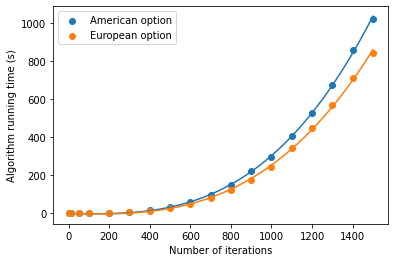

In [230]:
american_runtime = performance_data_optimized.loc[True,:]
european_runtime = performance_data_optimized.loc[False,:]
plt.scatter(american_runtime.index, american_runtime["Running time"]*10**-9, label = "American option")
plt.scatter(european_runtime.index, european_runtime["Running time"]*10**-9, label = "European option")
parameters_american, _ = curve_fit(lambda x,a,b,c: a*x**3 + b*x**2 + c*x, american_runtime.index, american_runtime["Running time"]*10**-9)
parameters_european, _ = curve_fit(lambda x,a,b,c: a*x**3 + b*x**2 + c*x, european_runtime.index, european_runtime["Running time"]*10**-9)
x = np.linspace(0,N[-1])
y_american = parameters_american[0]*x**3 + parameters_american[1]*x**2 + parameters_american[2]*x
y_european = parameters_european[0]*x**3 + parameters_european[1]*x**2 + parameters_european[2]*x
plt.xlabel("Number of iterations")
plt.ylabel("Algorithm running time (s)")
plt.legend()

plt.plot(
    x,
    y_american)
plt.plot(
x,
y_european)

plt.savefig("algo_runtime.eps")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


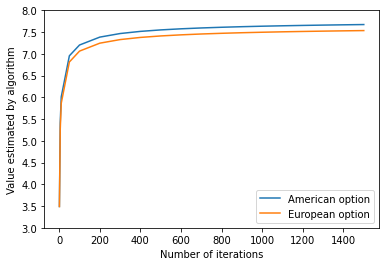

In [250]:
american_value = performance_data_optimized.loc[True,:]
european_value = performance_data_optimized.loc[False,:]
plt.plot(american_value.index, american_value["Value produced"], label = "American option")
plt.plot(european_runtime.index, european_value["Value produced"], label = "European option")
x = np.linspace(0,N[-1])

plt.xlabel("Number of iterations")
plt.ylabel("Value estimated by algorithm")
plt.legend()
plt.ylim(3,8)
plt.yticks(np.arange(3,8.5,0.5))
plt.savefig("algoConvergence.eps")

In [241]:
american_value[6:]["Value produced"]


Number of iterations
300     7.467117
400     7.516605
500     7.550583
600     7.575781
700     7.595430
800     7.611310
900     7.624490
1000    7.635662
1100    7.645288
1200    7.653695
1300    7.661121
1400    7.667744
1500    7.673699
Name: Value produced, dtype: float64

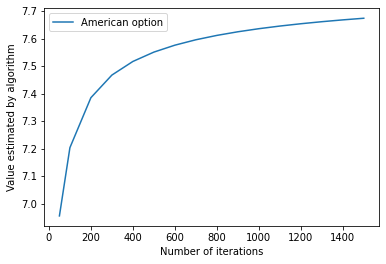

In [243]:

#european_value = performance_data_optimized.loc[(False, 300):(False, 1500)]
plt.plot(american_value[3:]["Value produced"], label = "American option")
#plt.plot(european_value.index, european_value["Value produced"], label = "European option")
x = np.linspace(0,N[-1])

plt.xlabel("Number of iterations")
plt.ylabel("Value estimated by algorithm")
plt.legend()
